In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
none_df = pd.concat([pd.read_hdf("data/none_stats.h5", "table"), pd.read_hdf("data/none_stats_extratrain.h5", "table")])

In [5]:
none_df = none_df.drop(['user_dim10', 'user_dim11', 'user_dim12', 'user_dim13', 'user_dim14',
                        'indprod_num_products_ow_2_reg',
       'indprod_num_products_ow_4_reg', 'indprod_num_products_ow_8_reg',
       'indprod_num_products_ow_16_reg', 'indprod_num_products_ow_32_reg',
       'indprod_num_products_dw_8_reg', 'indprod_num_products_dw_16_reg',
       'indprod_num_products_dw_32_reg', 'indprod_num_products_dw_64_reg',
       'indprod_num_products_dw_128_reg', 'indprod_num_products_dcos_14_reg',
       'indprod_num_products_dsin_14_reg', 'indprod_num_products_dcos_30_reg',
       'indprod_num_products_dsin_30_reg','indprod_dow_sin', 'indprod_dow_cos',
       'indprod_hod_sin', 'indprod_hod_cos','user_dow_sin', 'user_dow_cos',
       'user_hod_sin', 'user_hod_cos','order_dow_sin', 'order_dow_cos', 'order_hod_sin',
       'order_hod_cos'], axis=1)

In [7]:
none_df.columns

Index(['user_id', 'product_id', 'indprod_num_orders',
       'indprod_num_products_dw_8', 'indprod_num_products_dw_16',
       'indprod_num_products_dw_32', 'indprod_num_products_dw_64',
       'indprod_num_products_dw_128', 'indprod_num_products_dcos_14',
       'indprod_num_products_dsin_14', 'indprod_num_products_dcos_30',
       'indprod_num_products_dsin_30', 'indprod_num_products_ow_2',
       'indprod_num_products_ow_4', 'indprod_num_products_ow_8',
       'indprod_num_products_ow_16', 'indprod_num_products_ow_32',
       'indprod_inorder_1', 'indprod_inorder_2', 'indprod_days_since_last',
       'indprod_orders_since_last', 'indprod_proportion_orders',
       'indprod_days_per_order', 'user_num_products', 'user_mean_products',
       'user_num_days', 'user_num_orders', 'user_days_per_order',
       'user_days_per_order_mean', 'user_days_per_order_std', 'order_id',
       'eval_set', 'days_since_prior_order', 'absolute_date',
       'max_order_number', 'max_absolute_date', 'user

In [4]:
#none_df['prediction'] = 0
#all_users = none_df.loc[none_df.eval_set == "train", "user_id"].unique()
#np.random.seed(12134)
#np.random.shuffle(all_users)


# In[53]:

#valid_set = pd.DataFrame({'user_id': all_users, 'validation_set': np.arange(0, all_users.shape[0]) % 11})


# In[56]:
#none_df = none_df.merge(valid_set, on='user_id', how='left')


# In[58]:

#none_df.validation_set = none_df.validation_set.fillna(-1)


In [5]:
#none_df = none_df.merge((pd.read_csv('rawpredictions/glove_ind0.csv').groupby('user_id')
#               .agg({'validation_set': np.mean}).reset_index()), 
#              on='user_id')


In [6]:
none_df = none_df.drop([x for x in none_df.columns.values if '_reg' in x], axis=1)

In [8]:
none_df['prediction'] = 0

In [9]:
predictions_df = none_df[["eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"]].copy()

In [21]:
import xgboost as xgb
prior_test = none_df.loc[none_df.eval_set == "test", :]
d_test = xgb.DMatrix(prior_test.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).as_matrix(),
                            feature_names=prior_test.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).columns.values.tolist(),
                     )

for v in range(10):
    predictions_df['prediction_'+str(v)] = 0
    prior_train = none_df.loc[(none_df.eval_set != "test") & (none_df.validation_set != v) & (none_df.validation_set != 10), :]
    prior_valid = none_df.loc[none_df.validation_set == v, :]
    prior_valid_2 = none_df.loc[none_df.validation_set == 10, :]

    d_train = xgb.DMatrix(prior_train.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).values,
                          feature_names=prior_train.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).columns.values.tolist(),
                          label=prior_train.reordered.as_matrix())
    d_valid = xgb.DMatrix(prior_valid.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).values,
                          feature_names=prior_valid.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).columns.values.tolist(),
                          label=prior_valid.reordered.as_matrix())
    d_valid_2 = xgb.DMatrix(prior_valid_2.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).values,
                            feature_names=prior_valid_2.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id", "extratrain"], axis=1).columns.values.tolist(),
                            label=prior_valid_2.reordered.as_matrix())
    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.05
    params['max_depth'] = 4
    params['nthread'] = 12
    params['gamma'] = 0
    params['min_child_weight'] = 0
    params['colsample_bytree'] = .5


    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    print("fold:", v)
    bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10)
    #xgb.cv(params, d_train, 10000, nfold=5, early_stopping_rounds=20, verbose_eval=5)
    predictions_df.loc[none_df.eval_set == "test", 'prediction_' + str(v)] = bst.predict(d_test, ntree_limit=bst.best_ntree_limit+50)
    predictions_df.loc[(none_df.eval_set != "test") & (none_df.validation_set != v) & (none_df.validation_set != 10), 'prediction_' + str(v)] = bst.predict(d_train, ntree_limit=bst.best_ntree_limit+50)
    predictions_df.loc[none_df.validation_set == v, 'prediction_' + str(v)] = bst.predict(d_valid, ntree_limit=bst.best_ntree_limit+50)
    predictions_df.loc[none_df.validation_set == 10, 'prediction_' + str(v)] = bst.predict(d_valid_2, ntree_limit=bst.best_ntree_limit+50)


fold: 0
[0]	train-auc:0.806776	valid-auc:0.804212
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.818546	valid-auc:0.816594
[20]	train-auc:0.819589	valid-auc:0.817985
[30]	train-auc:0.821354	valid-auc:0.8189
[40]	train-auc:0.823653	valid-auc:0.820791
[50]	train-auc:0.826379	valid-auc:0.823836
[60]	train-auc:0.828887	valid-auc:0.826342
[70]	train-auc:0.830625	valid-auc:0.827509
[80]	train-auc:0.833186	valid-auc:0.830848
[90]	train-auc:0.835048	valid-auc:0.832307
[100]	train-auc:0.836533	valid-auc:0.833512
[110]	train-auc:0.837587	valid-auc:0.834399
[120]	train-auc:0.838904	valid-auc:0.835174
[130]	train-auc:0.840075	valid-auc:0.836298
[140]	train-auc:0.840913	valid-auc:0.836897
[150]	train-auc:0.841938	valid-auc:0.837673
[160]	train-auc:0.842732	valid-auc:0.838222
[170]	train-auc:0.84341	valid-auc:0.83866
[180]	train-auc:0.844179	valid-auc:0.83906
[190]	train-auc:0.844847	vali

Stopping. Best iteration:
[771]	train-auc:0.866626	valid-auc:0.823835

fold: 3
[0]	train-auc:0.802108	valid-auc:0.79393
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.818644	valid-auc:0.814453
[20]	train-auc:0.819783	valid-auc:0.814195
[30]	train-auc:0.821429	valid-auc:0.814698
[40]	train-auc:0.823638	valid-auc:0.81636
[50]	train-auc:0.826462	valid-auc:0.818462
[60]	train-auc:0.82912	valid-auc:0.820164
[70]	train-auc:0.830781	valid-auc:0.821777
[80]	train-auc:0.833379	valid-auc:0.823794
[90]	train-auc:0.835275	valid-auc:0.825655
[100]	train-auc:0.836843	valid-auc:0.826646
[110]	train-auc:0.838031	valid-auc:0.827197
[120]	train-auc:0.839304	valid-auc:0.8282
[130]	train-auc:0.840338	valid-auc:0.828885
[140]	train-auc:0.841268	valid-auc:0.82951
[150]	train-auc:0.842182	valid-auc:0.829761
[160]	train-auc:0.843036	valid-auc:0.83014
[170]	train-auc:0.843847	valid-auc:0.830622
[180

[20]	train-auc:0.819735	valid-auc:0.815597
[30]	train-auc:0.821602	valid-auc:0.817188
[40]	train-auc:0.823362	valid-auc:0.818928
[50]	train-auc:0.826442	valid-auc:0.822187
[60]	train-auc:0.829077	valid-auc:0.824336
[70]	train-auc:0.830777	valid-auc:0.825417
[80]	train-auc:0.833336	valid-auc:0.828063
[90]	train-auc:0.83513	valid-auc:0.829496
[100]	train-auc:0.836641	valid-auc:0.830573
[110]	train-auc:0.837805	valid-auc:0.831099
[120]	train-auc:0.839116	valid-auc:0.831991
[130]	train-auc:0.840128	valid-auc:0.832508
[140]	train-auc:0.841154	valid-auc:0.833006
[150]	train-auc:0.842012	valid-auc:0.833506
[160]	train-auc:0.842846	valid-auc:0.833929
[170]	train-auc:0.84365	valid-auc:0.834036
[180]	train-auc:0.844494	valid-auc:0.834487
[190]	train-auc:0.845161	valid-auc:0.834762
[200]	train-auc:0.845918	valid-auc:0.835152
[210]	train-auc:0.84653	valid-auc:0.835279
[220]	train-auc:0.847193	valid-auc:0.835507
[230]	train-auc:0.847784	valid-auc:0.835629
[240]	train-auc:0.84841	valid-auc:0.835812


[430]	train-auc:0.856904	valid-auc:0.834747
Stopping. Best iteration:
[381]	train-auc:0.855116	valid-auc:0.834937

fold: 9
[0]	train-auc:0.801592	valid-auc:0.806117
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.818508	valid-auc:0.818566
[20]	train-auc:0.819416	valid-auc:0.818861
[30]	train-auc:0.821334	valid-auc:0.820275
[40]	train-auc:0.823501	valid-auc:0.822756
[50]	train-auc:0.826419	valid-auc:0.825671
[60]	train-auc:0.828957	valid-auc:0.82837
[70]	train-auc:0.830509	valid-auc:0.829443
[80]	train-auc:0.833198	valid-auc:0.831472
[90]	train-auc:0.835099	valid-auc:0.832439
[100]	train-auc:0.836655	valid-auc:0.833558
[110]	train-auc:0.837907	valid-auc:0.834345
[120]	train-auc:0.83908	valid-auc:0.835353
[130]	train-auc:0.84014	valid-auc:0.835788
[140]	train-auc:0.841099	valid-auc:0.836386
[150]	train-auc:0.842004	valid-auc:0.836569
[160]	train-auc:0.84278	valid-auc:0.836812
[

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
for i in range(10):
    predictions_df['prediction_'+str(i)] = np.log(predictions_df['prediction_'+str(i)] / (1 - predictions_df['prediction_'+str(i)]))

In [24]:
roc_auc_score(none_df.query('validation_set == 10').reordered, predictions_df.query('validation_set == 10').loc[:, 'prediction_0':'prediction_9'].mean(axis=1))

0.83461546136653897

In [15]:
0.83522693258011138

0.8352269325801114

In [19]:
pd.Series(bst.get_score(importance_type='gain')).sort_values()

indprod_num_orders                 4.876229
indprod_hod_avg_diff               5.669030
indprod_dow_avg_diff               5.750356
indprod_day_proportion             5.796786
indprod_num_products_dw_8          5.859224
indprod_inorder_2                  5.903014
user_hod_avg_diff                  6.294877
indprod_num_products_dcos_14       6.422254
indprod_num_products_dw_16         6.499652
indprod_num_products_dsin_30       6.656509
user_num_days                      6.696330
user_dim3                          6.706446
user_dim9                          6.724685
indprod_hod_proportion             6.739785
user_dim6                          6.882539
user_dim1                          7.068745
user_dim4                          7.167447
user_dow_avg_diff                  7.309590
indprod_num_products_dsin_14       7.322219
user_hod_proportion                7.338708
user_dim8                          7.352647
indprod_num_products_dcos_30       7.429209
absolute_date                   

In [14]:
none_df['prediction'] = predictions_df.loc[:, 'prediction_0':'prediction_9'].mean(axis=1)
none_df['prediction'] = 1.0/(1.0+np.exp(-none_df['prediction']))

In [12]:
raw_output = none_df.loc[:,['prediction', 'eval_set', 'validation_set', 'order_id', 'product_id', 'user_id', 'user_distinct_products', 'reordered']]
raw_output.to_csv("rawpredictions/nones.csv", index=False)


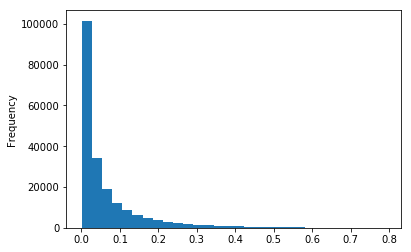

In [60]:
none_df.prediction.plot.hist(bins=30)

In [18]:
none_df.shape

(412418, 91)